In [10]:
# Non_default import install
!pip install scikit-posthocs --quiet

import numpy as np
import pandas as pd
from scipy import stats
import scikit_posthocs as sp  # For Nemenyi post-hoc
import matplotlib.pyplot as plt
from google.colab import files
import os
import itertools
from textwrap import indent

# Display
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

print("Setup complete.")
print("Versions:")
print(f"  pandas: {pd.__version__}")
print(f"  numpy:  {np.__version__}")
print(f"  scipy:  {stats.__version__ if hasattr(stats, '__version__') else 'n/a'}")
print(f"  scikit-posthocs: {sp.__version__ if hasattr(sp, '__version__') else 'n/a'}")

Setup complete.
Versions:
  pandas: 2.2.2
  numpy:  2.0.2
  scipy:  n/a
  scikit-posthocs: 0.11.4


In [11]:
print("Upload file (CSV or Excel).")
uploaded = files.upload()

if not uploaded:
    raise RuntimeError("No file uploaded.")

# Get uploaded file name
filename = next(iter(uploaded.keys()))
file_ext = os.path.splitext(filename)[1].lower()

if file_ext in [".csv"]:
    df = pd.read_csv(filename)
elif file_ext in [".xls", ".xlsx"]:
    df = pd.read_excel(filename)
else:
    raise ValueError(
        f"Unsupported file extension '{file_ext}'. "
    )

print(f"\nLoaded file: {filename}")
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns\n")

print("Column names:")
print(list(df.columns))

print("\nData preview (first 5 rows):")
display(df.head())

Upload file (CSV or Excel).


Saving Results_combined.xlsx to Results_combined (1).xlsx

Loaded file: Results_combined (1).xlsx
Shape: 40 rows × 17 columns

Column names:
['dataset_id', 'dataset_name', 'approach', 'model_type', 'hyperparameters', 'cv_accuracy_mean', 'cv_accuracy_std', 'test_accuracy', 'test_balanced_accuracy', 'test_f1_macro', 'test_f1_weighted', 'optimization_time', 'training_time', 'feature_engineering', 'rationale', 'pipeline_str', 'hyperparameters_json']

Data preview (first 5 rows):


,dataset_id,dataset_name,approach,model_type,hyperparameters,cv_accuracy_mean,cv_accuracy_std,test_accuracy,test_balanced_accuracy,test_f1_macro,test_f1_weighted,optimization_time,training_time,feature_engineering,rationale,pipeline_str,hyperparameters_json
0,37,diabetes,ChatGPT,rbf_svm,"model_type=rbf_svm, feature_engineering_mode=n...",0.783407,0.034219,0.727273,0.670741,0.678465,0.715884,74.249551,0.048815,none,NaN,NaN,"{""feature_engineering_mode"": ""none"", ""model_ty..."
1,61,iris,ChatGPT,rbf_svm,"model_type=rbf_svm, feature_engineering_mode=n...",0.975000,0.020412,1.000000,1.000000,1.000000,1.000000,58.822498,0.006820,none,NaN,NaN,"{""feature_engineering_mode"": ""none"", ""model_ty..."
2,44,spambase,ChatGPT,hist_gradient_boosting,"model_type=hist_gradient_boosting, feature_eng...",0.959239,0.006711,0.945711,0.944126,0.943271,0.945762,648.404413,0.827367,light,NaN,NaN,"{""feature_engineering_mode"": ""light"", ""model_t..."
3,1510,wdbc,ChatGPT,linear_svm,"model_type=linear_svm, feature_engineering_mod...",0.980220,0.017582,0.991228,0.988095,0.990528,0.991205,92.589967,0.007440,light,NaN,NaN,"{""feature_engineering_mode"": ""light"", ""model_t..."
4,23,cmc,ChatGPT,random_forest,"model_type=random_forest, feature_engineering_...",0.566199,0.025444,0.583051,0.554973,0.557589,0.578160,135.937141,1.435496,none,NaN,NaN,"{""feature_engineering_mode"": ""none"", ""model_ty..."


In [19]:
print("Available columns in the dataset:")
print(list(df.columns))
print()

# --- Ask for metric column ---
metric_col = "test_f1_weighted"

if metric_col not in df.columns:
    raise ValueError(
        f"Column '{metric_col}' not found in the dataset.\n"
        f"Available columns are: {list(df.columns)}"
    )

higher_is_better = True

print(f"  Metric column:      {metric_col}")
print(f"  Higher is better:   {higher_is_better}")

Available columns in the dataset:
['dataset_id', 'dataset_name', 'approach', 'model_type', 'hyperparameters', 'cv_accuracy_mean', 'cv_accuracy_std', 'test_accuracy', 'test_balanced_accuracy', 'test_f1_macro', 'test_f1_weighted', 'optimization_time', 'training_time', 'feature_engineering', 'rationale', 'pipeline_str', 'hyperparameters_json']

  Metric column:      test_f1_weighted
  Higher is better:   True


In [20]:
dataset_col = "dataset_id"
approach_col = "approach"

print(f"  Dataset column:   {dataset_col}")
print(f"  Approach column:  {approach_col}")
print(f"  Metric column:    {metric_col}")
print(f"  Higher is better: {higher_is_better}")

#Drop rows with missing required columns

required_cols = [dataset_col, approach_col, metric_col]
rows_before = df.shape[0]

df_clean = df.dropna(subset=required_cols).copy()
rows_after_na = df_clean.shape[0]

print(f"Dropped {rows_before - rows_after_na} rows with missing values in {required_cols}.")

# Unique approaches present
approaches = sorted(df_clean[approach_col].unique())
k = len(approaches)

if k < 2:
    raise ValueError(
        f"Only {k} unique approaches found in column '{approach_col}'. "
        "You need at least 2 to run Friedman/Nemenyi."
    )

# Count how many distinct approaches per dataset
counts = df_clean.groupby(dataset_col)[approach_col].nunique()

complete_datasets = counts[counts == k].index
incomplete_datasets = counts[counts != k].index

print(f"\nNumber of unique approaches: {k}")
print(f"Number of datasets before ensuring completeness: {counts.shape[0]}")
print(f"Datasets with all {k} approaches: {len(complete_datasets)}")
print(f"Datasets with missing approaches: {len(incomplete_datasets)}")

if len(incomplete_datasets) > 0:
    print("\nWarning: The following datasets do NOT have results for all approaches "
          "and will be removed for the Friedman test:")
    print(list(incomplete_datasets))

# Keep only complete datasets
df_clean = df_clean[df_clean[dataset_col].isin(complete_datasets)].copy()
rows_after_blocks = df_clean.shape[0]

print(f"\nRows after removing incomplete datasets: {rows_after_blocks}")

if df_clean[dataset_col].nunique() < 2:
    raise ValueError(
        "Less than 2 complete datasets remain after cleaning. "
        "Friedman test requires at least 2 datasets."
    )

print("\nCleaned data summary:")
print(f"  #Datasets (complete): {df_clean[dataset_col].nunique()}")
print(f"  #Approaches:          {k}")
print(f"  #Rows:                {df_clean.shape[0]}")

print("\nPreview of cleaned data:")
display(df_clean.head())

  Dataset column:   dataset_id
  Approach column:  approach
  Metric column:    test_f1_weighted
  Higher is better: True
Dropped 0 rows with missing values in ['dataset_id', 'approach', 'test_f1_weighted'].

Number of unique approaches: 4
Number of datasets before ensuring completeness: 10
Datasets with all 4 approaches: 10
Datasets with missing approaches: 0

Rows after removing incomplete datasets: 40

Cleaned data summary:
  #Datasets (complete): 10
  #Approaches:          4
  #Rows:                40

Preview of cleaned data:


,dataset_id,dataset_name,approach,model_type,hyperparameters,cv_accuracy_mean,cv_accuracy_std,test_accuracy,test_balanced_accuracy,test_f1_macro,test_f1_weighted,optimization_time,training_time,feature_engineering,rationale,pipeline_str,hyperparameters_json
0,37,diabetes,ChatGPT,rbf_svm,"model_type=rbf_svm, feature_engineering_mode=n...",0.783407,0.034219,0.727273,0.670741,0.678465,0.715884,74.249551,0.048815,none,NaN,NaN,"{""feature_engineering_mode"": ""none"", ""model_ty..."
1,61,iris,ChatGPT,rbf_svm,"model_type=rbf_svm, feature_engineering_mode=n...",0.975000,0.020412,1.000000,1.000000,1.000000,1.000000,58.822498,0.006820,none,NaN,NaN,"{""feature_engineering_mode"": ""none"", ""model_ty..."
2,44,spambase,ChatGPT,hist_gradient_boosting,"model_type=hist_gradient_boosting, feature_eng...",0.959239,0.006711,0.945711,0.944126,0.943271,0.945762,648.404413,0.827367,light,NaN,NaN,"{""feature_engineering_mode"": ""light"", ""model_t..."
3,1510,wdbc,ChatGPT,linear_svm,"model_type=linear_svm, feature_engineering_mod...",0.980220,0.017582,0.991228,0.988095,0.990528,0.991205,92.589967,0.007440,light,NaN,NaN,"{""feature_engineering_mode"": ""light"", ""model_t..."
4,23,cmc,ChatGPT,random_forest,"model_type=random_forest, feature_engineering_...",0.566199,0.025444,0.583051,0.554973,0.557589,0.578160,135.937141,1.435496,none,NaN,NaN,"{""feature_engineering_mode"": ""none"", ""model_ty..."


In [21]:
# Determine ranking order:
# - pandas rank(ascending=True) → smallest value gets rank 1
# - if higher_is_better, we want the largest value to get rank 1 → ascending=False
ascending_flag = not higher_is_better

def rank_within_dataset(group):
    # Compute ranks for the metric within this dataset
    ranks = group[metric_col].rank(
        method="average",   # average ranks for ties (standard for Friedman)
        ascending=ascending_flag
    )
    group = group.copy()
    group["rank"] = ranks
    return group

df_ranked = df_clean.groupby(dataset_col, group_keys=False).apply(rank_within_dataset)

# Pivot to get rank matrix: rows = datasets, columns = approaches, values = ranks
rank_matrix = df_ranked.pivot_table(
    index=dataset_col,
    columns=approach_col,
    values="rank",
    aggfunc="mean"   # in case of duplicate (dataset, approach), average their ranks
)

# Ensure columns are in a consistent order
rank_matrix = rank_matrix.reindex(sorted(rank_matrix.columns), axis=1)

print("Rank matrix (datasets × approaches):")
display(rank_matrix.head())

# Compute mean rank per approach
mean_ranks = rank_matrix.mean(axis=0).to_frame(name="mean_rank")
mean_ranks_sorted = mean_ranks.sort_values("mean_rank")

print("\nMean ranks per approach (lower = better):")
display(mean_ranks_sorted)

Rank matrix (datasets × approaches):


/tmp/ipython-input-2202932362.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_ranked = df_clean.groupby(dataset_col, group_keys=False).apply(rank_within_dataset)


approach,ChatGPT,baseline,llm,tpot
dataset_id,,,,
23,2.0,4.0,3.0,1.0
37,4.0,2.0,3.0,1.0
39,2.0,3.0,1.0,4.0
40,4.0,1.0,2.0,3.0
41,2.0,1.0,4.0,3.0



Mean ranks per approach (lower = better):


,mean_rank
approach,
ChatGPT,2.15
baseline,2.35
llm,2.75
tpot,2.75


In [22]:
#Friedman Test

from scipy.stats import friedmanchisquare

# Basic dimensions
n_datasets = rank_matrix.shape[0]
k_approaches = rank_matrix.shape[1]

print("Running Friedman test...")
print(f"  #Datasets:  {n_datasets}")
print(f"  #Approaches: {k_approaches}")

if n_datasets < 2 or k_approaches < 2:
    raise ValueError(
        "Friedman test requires at least 2 datasets and 2 approaches.\n"
        f"Currently have {n_datasets} datasets and {k_approaches} approaches."
    )

#Significance level
alpha = 0.05

# Prepare data for scipy's friedmanchisquare: one array per approach
# Each array is the ranks of that approach across all datasets
approach_names = list(rank_matrix.columns)
samples = [rank_matrix[ap].values for ap in approach_names]

friedman_stat, friedman_p = friedmanchisquare(*samples)

df_friedman = k_approaches - 1  # degrees of freedom

print("\nFriedman test results:")
print("----------------------")
print(f"  χ²_F statistic : {friedman_stat:.4f}")
print(f"  Degrees of freedom: {df_friedman}")
print(f"  p-value        : {friedman_p:.6f}")
print(f"  alpha          : {alpha:.4f}")

# Null hypothesis: all approaches perform equally well on average.
friedman_significant = friedman_p < alpha

if friedman_significant:
    print("\nDecision: Reject H0.")
    print("Conclusion: There is a statistically significant difference between at least two approaches.")
else:
    print("\nDecision: Fail to reject H0.")
    print("Conclusion: No statistically significant differences detected between approaches at this alpha.")

# Store results for later cells
friedman_results = {
    "statistic": friedman_stat,
    "p_value": friedman_p,
    "df": df_friedman,
    "alpha": alpha,
    "significant": friedman_significant,
    "n_datasets": n_datasets,
    "k_approaches": k_approaches,
    "approach_names": approach_names,
}

print("\nFriedman test results stored in `friedman_results` and flag `friedman_significant`.")

Running Friedman test...
  #Datasets:  10
  #Approaches: 4

Friedman test results:
----------------------
  χ²_F statistic : 1.6531
  Degrees of freedom: 3
  p-value        : 0.647419
  alpha          : 0.0500

Decision: Fail to reject H0.
Conclusion: No statistically significant differences detected between approaches at this alpha.

Friedman test results stored in `friedman_results` and flag `friedman_significant`.


In [23]:
#Nemenyi post-hoc test IF the Friedman test was significant

if not friedman_results["significant"]:
    print("Friedman test was NOT significant.")
    print("No post-hoc Nemenyi test will be run.")
else:
    print("Friedman test was significant.")
    print("Running Nemenyi post-hoc test...\n")

    # Nemenyi post-hoc test using scikit-posthocs
    # Input shape: rows = datasets, columns = approaches
    nemenyi_pvals = sp.posthoc_nemenyi_friedman(rank_matrix.values)

    # Label rows/columns with approach names
    nemenyi_pvals.index = friedman_results["approach_names"]
    nemenyi_pvals.columns = friedman_results["approach_names"]

    print("Pairwise Nemenyi p-values (approaches × approaches):")
    display(nemenyi_pvals)

    # Build a tidy decision table: one row per pair of approaches
    alpha = friedman_results["alpha"]
    pairs = []
    for a, b in itertools.combinations(friedman_results["approach_names"], 2):
        p = nemenyi_pvals.loc[a, b]
        significant = p < alpha
        pairs.append({
            "approach_1": a,
            "approach_2": b,
            "p_value": p,
            f"significant_at_alpha_{alpha}": significant,
        })

    nemenyi_results = pd.DataFrame(pairs)

    # Sort by p-value ascending (strongest evidence first)
    nemenyi_results = nemenyi_results.sort_values("p_value").reset_index(drop=True)

    print("\nPairwise Nemenyi test results (tidy format):")
    display(nemenyi_results)

    print("\nSummary:")
    print(f"  Significance level alpha: {alpha}")
    print("  TRUE in the 'significant_at_alpha_*' column means the two approaches")
    print("  have significantly different average ranks according to the Nemenyi test.\n")

    # Store for later cells
    posthoc_nemenyi_pvals = nemenyi_pvals
    posthoc_nemenyi_results = nemenyi_results

    print("Stored objects:")
    print("  posthoc_nemenyi_pvals   — square matrix of p-values")
    print("  posthoc_nemenyi_results — tidy pairwise table")


Friedman test was NOT significant.
No post-hoc Nemenyi test will be run.


In [24]:
# Summary

print("======================================")
print("  Statistical Comparison Summary")
print("======================================\n")

# --- Data overview ---
n_datasets = friedman_results["n_datasets"]
k_approaches = friedman_results["k_approaches"]
alpha = friedman_results["alpha"]

print("Data & Setup")
print("------------")
print(f"Number of complete datasets used: {n_datasets}")
print(f"Number of approaches compared:    {k_approaches}")
print(f"Dataset column:                   '{dataset_col}'")
print(f"Approach column:                  '{approach_col}'")
print(f"Metric column:                    '{metric_col}'")
print(f"Higher metric value is better?:   {higher_is_better}")
print(f"Significance level (alpha):       {alpha:.4f}\n")

print("Approaches included:")
for ap in friedman_results["approach_names"]:
    print(f"  - {ap}")
print()

# --- Mean ranks ---
print("Mean Ranks per Approach")
print("------------------------")
print("Lower mean rank = better overall performance (1 = best).")
display(mean_ranks_sorted)

# Build a compact textual version
print("\nMean ranks (compact):")
for ap, row in mean_ranks_sorted.itertuples():
    print(f"  {ap}: {row:.4f}")

# --- Friedman test summary ---
print("\nFriedman Test")
print("-------------")
print(f"χ²_F statistic : {friedman_results['statistic']:.4f}")
print(f"Degrees of freedom: {friedman_results['df']}")
print(f"p-value        : {friedman_results['p_value']:.6f}")

if friedman_significant:
    print("\nDecision: Reject H0 (at alpha = {:.4f}).".format(alpha))
    print("Conclusion: There is a statistically significant difference\n"
          "in average performance among the approaches.\n")
else:
    print("\nDecision: Fail to reject H0 (at alpha = {:.4f}).".format(alpha))
    print("Conclusion: No statistically significant differences were detected\n"
          "between the approaches at this significance level.\n")

# --- Nemenyi summary (if applicable) ---
if friedman_significant and "posthoc_nemenyi_results" in globals():
    print("Post-hoc Nemenyi Test (Pairwise Differences)")
    print("-------------------------------------------")
    sig_col = f"significant_at_alpha_{alpha}"

    # Split pairs into significant and non-significant
    sig_pairs = posthoc_nemenyi_results[posthoc_nemenyi_results[sig_col]]
    nonsig_pairs = posthoc_nemenyi_results[~posthoc_nemenyi_results[sig_col]]

    if len(sig_pairs) == 0:
        print("No individual pairs were found to be significantly different\n"
              f"after Nemenyi correction at alpha = {alpha}.")
    else:
        print("Pairs with significant differences in average rank:")
        for _, row in sig_pairs.iterrows():
            a1 = row["approach_1"]
            a2 = row["approach_2"]
            p  = row["p_value"]
            print(f"  {a1} vs {a2}: p = {p:.6f}  (significant)")

    if len(nonsig_pairs) > 0:
        print("\nPairs with NO significant difference (Nemenyi, same alpha):")
        for _, row in nonsig_pairs.iterrows():
            a1 = row["approach_1"]
            a2 = row["approach_2"]
            p  = row["p_value"]
            print(f"  {a1} vs {a2}: p = {p:.6f}  (not significant)")

    print("\nInterpretation notes:")
    print("  - If two approaches differ significantly, their average performance")
    print("    (as captured by ranks across datasets) is unlikely to be due")
    print("    to random variation alone at the chosen alpha.")
    print("  - If they do not differ significantly, the data does not provide")
    print("    strong enough evidence to distinguish them statistically.\n")
else:
    print("No Nemenyi post-hoc summary to report "
          "(either Friedman not significant or post-hoc not run).")

print("======================================")
print("End of summary.")
print("======================================")


  Statistical Comparison Summary

Data & Setup
------------
Number of complete datasets used: 10
Number of approaches compared:    4
Dataset column:                   'dataset_id'
Approach column:                  'approach'
Metric column:                    'test_f1_weighted'
Higher metric value is better?:   True
Significance level (alpha):       0.0500

Approaches included:
  - ChatGPT
  - baseline
  - llm
  - tpot

Mean Ranks per Approach
------------------------
Lower mean rank = better overall performance (1 = best).


,mean_rank
approach,
ChatGPT,2.15
baseline,2.35
llm,2.75
tpot,2.75



Mean ranks (compact):
  ChatGPT: 2.1500
  baseline: 2.3500
  llm: 2.7500
  tpot: 2.7500

Friedman Test
-------------
χ²_F statistic : 1.6531
Degrees of freedom: 3
p-value        : 0.647419

Decision: Fail to reject H0 (at alpha = 0.0500).
Conclusion: No statistically significant differences were detected
between the approaches at this significance level.

No Nemenyi post-hoc summary to report (either Friedman not significant or post-hoc not run).
End of summary.


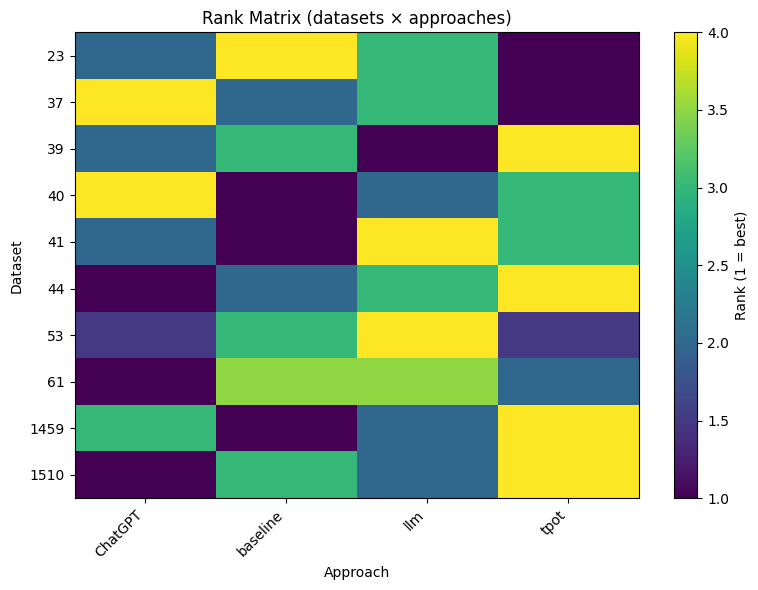

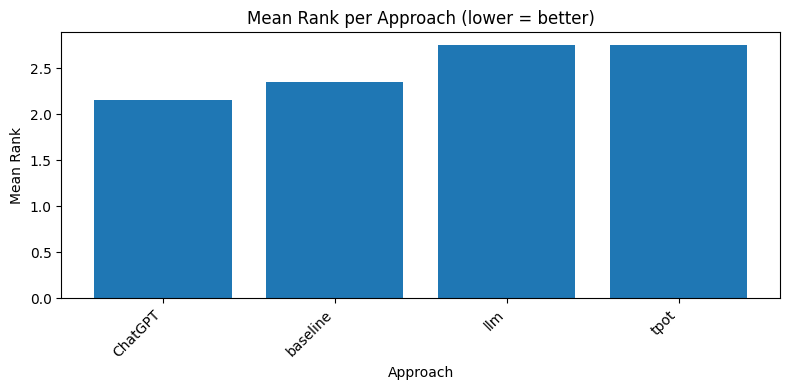

In [25]:
# Cell 9 Visualizations

if 'rank_matrix' not in globals():
    raise RuntimeError("rank_matrix not found. Please run Cells 4–5 first.")

if 'mean_ranks_sorted' not in globals():
    raise RuntimeError("mean_ranks_sorted not found. Please run Cell 5 first.")

# -------- 1. Heatmap of ranks (datasets × approaches) --------
fig, ax = plt.subplots(figsize=(8, 6))

im = ax.imshow(rank_matrix.values, aspect='auto')  # default colormap

ax.set_title("Rank Matrix (datasets × approaches)")
ax.set_xlabel("Approach")
ax.set_ylabel("Dataset")

# Tick labels
ax.set_xticks(range(rank_matrix.shape[1]))
ax.set_xticklabels(rank_matrix.columns, rotation=45, ha="right")

ax.set_yticks(range(rank_matrix.shape[0]))
ax.set_yticklabels(rank_matrix.index)

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Rank (1 = best)", rotation=90)

plt.tight_layout()
plt.show()

# -------- 2. Bar plot of mean ranks per approach --------
fig, ax = plt.subplots(figsize=(8, 4))

approaches = list(mean_ranks_sorted.index)
mean_ranks_vals = mean_ranks_sorted["mean_rank"].values

ax.bar(approaches, mean_ranks_vals)

ax.set_title("Mean Rank per Approach (lower = better)")
ax.set_xlabel("Approach")
ax.set_ylabel("Mean Rank")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
